In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:

# imports
import random
import math

import numpy as np
import scipy
import scipy.misc
import scipy.integrate
import pandas as pd

import torch

import torch.nn
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.patheffects
from sith import SITH
import seaborn as sn
sn.set_context("poster")

# Test 1: Basic signal through time. 

We are testing a SITH setup on a 1 second scale and adding in an input signal 
that occurs for one time step and viewing what that singal looks like through 
time in both Lapace space and inverse-Lapace space. 

In [3]:
# The SITH layer has a lot of different parameters that allow you to fine 
# tune exactly how compressed you want the historical representation to be.
#     Parameters
#     ----------
#     in_features: int
#         Number of tracked features
#     tau_0: float (default = 1)
#         The center of the first receptive field in inverse-Lapace space. 
#     dt: float (optional, default=None)
#         The presentation time-delta of each stimulus to the representation.
#         Likely to be the same value as tau_0, unless you want more granular
#         control of how things are presented to the representation. 
#     k: int
#         The spcificity of the receptive fields
#     c: float
#         The degree of historical compression. Smaller numbers means greater
#         numbers of tau*s will be dedicated to tracking the more recent past
#     alpha: float
#         
#     ntau: int
#         The desired number of taustars in the final representation, before
#         indexing with T_every
#     T_every: int
#         How many tau*s we skip when indexing into the inverse-laplace space
#         representation, T.
#
#############################################################################


sith_params ={"in_features":10,
              "tau_0":1, "k":4,
              "c":.05, "ntau":100, 
              "T_every":8, "alpha":1.0}

sithrep = SITH(**sith_params)
sithrep.cuda()
target_vec = torch.ones(1, 10).type(torch.cuda.DoubleTensor)
taustars = sithrep._tau_star[sith_params['k']:-sith_params['k']:sith_params['T_every']]
input_scale = 10
print(taustars)

tensor([  1.0000,   1.4775,   2.1829,   3.2251,   4.7649,   7.0400,  10.4013,
         15.3674,  22.7047,  33.5451,  49.5614,  73.2248, 108.1864],
       dtype=torch.float64)


In [4]:
target_vecs = torch.cat((target_vec, 
                         torch.zeros(9,10).type(torch.DoubleTensor).cuda()), 
                        dim=0)
print(target_vecs.shape)

torch.Size([10, 10])


Text(0.5,1,'One feature through time. ')

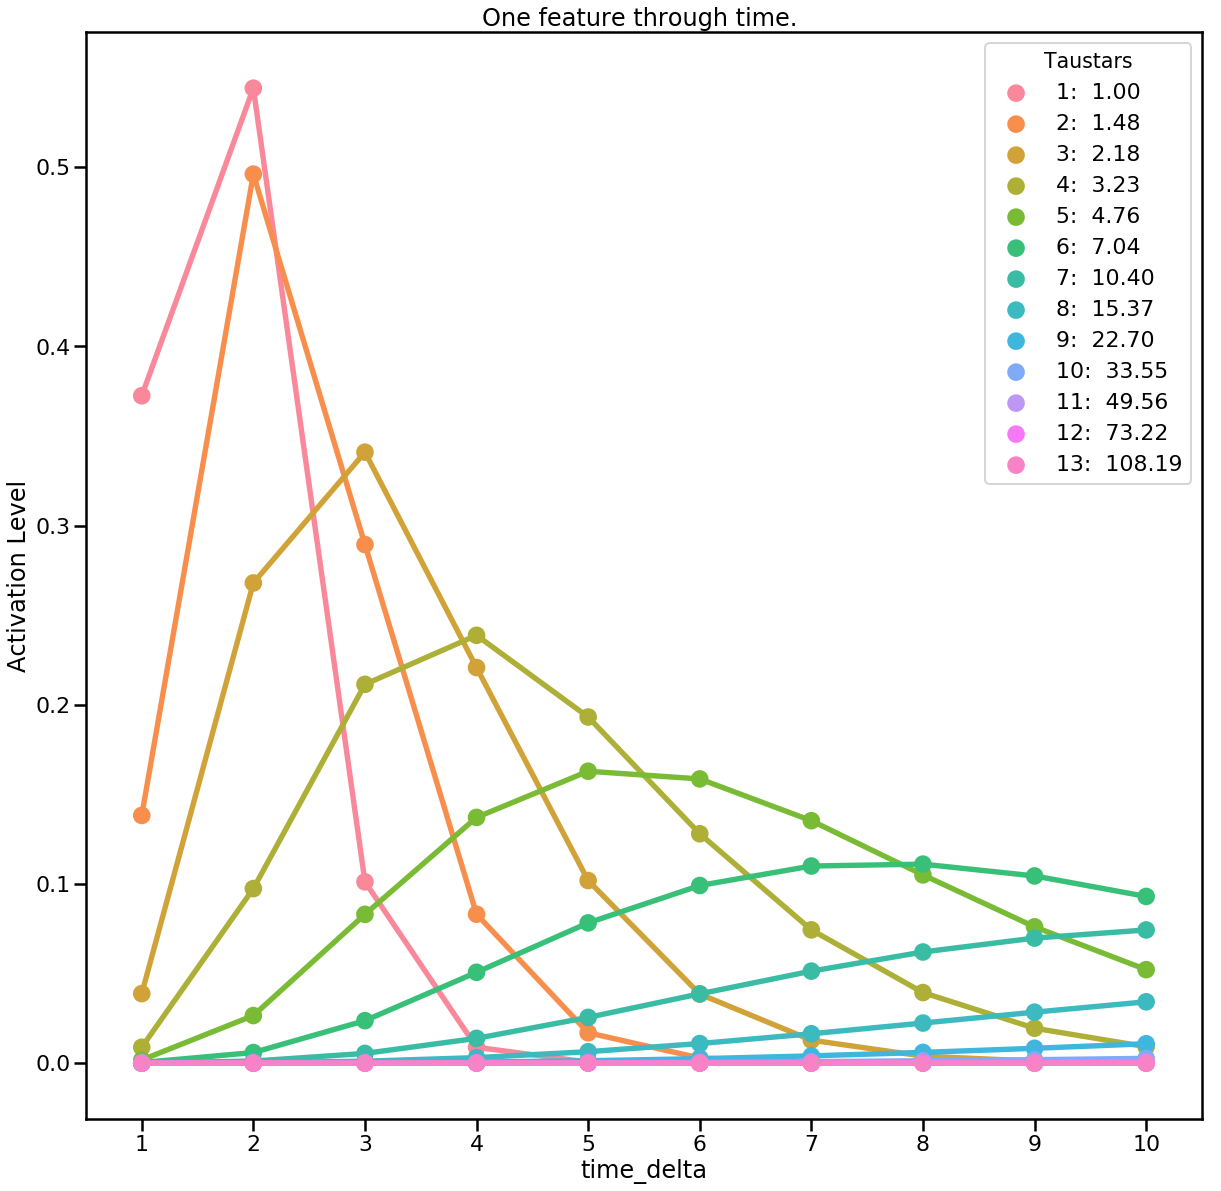

In [14]:
sithrep.reset()
dat = {"Taustars":[],
       "data":[],
       "time_delta":[]}

Ts = sithrep(target_vecs)
x = 0
for T in Ts.split(1,dim=0):
    for i in range(len(taustars)):
        dat["Taustars"].append("%i:  %.2f" % (i+1,taustars[i]))
        dat['time_delta'].append(x+1)
        dat['data'].append(T.detach().cpu().numpy()[0, i, 0])
    x += 1
sdat = pd.DataFrame(dat)
fig=figure(figsize=(20,20))
a = sn.pointplot(data=sdat, hue="Taustars", x="time_delta", y="data")
a.set_ylabel("Activation Level")
a.set_title("One feature through time")